# Compile **MediaPipe Hands** from ONNX into TVM

`TODO`
- export helpers & utils into my fork of hand-gesture-recognition-using-onnx repo. also translate the jupyter notebooks from Japanese.

## Reference

Author: Yunho Cho

This notebook is based on ["How to Compile Models from ONNX"](https://tvm.apache.org/docs/how_to/compile_models/from_onnx.html#sphx-glr-how-to-compile-models-from-onnx-py) by Joshua Z. Zhang.

## Setup

### Platform

In [1]:
def in_colab():
    try:
        from google.colab import drive
        return True
    except ImportError:
        return False

if in_colab():
    IN_COLAB = True
    print("This code is running in Google Colab")
else:
    IN_COLAB = False
    print("This code is not running in Google Colab")

This code is not running in Google Colab


In [2]:
import platform

OVERRIDE = None

system = platform.system()
if system == "Darwin":
    pycmd = 'python3'
    OVERRIDE = 'py -3.10' # MacBongPro
elif system == "Windows":
    pycmd = 'python3'
else: # linux
    pycmd = 'python3'
    OVERRIDE = 'py -3.11' # WSL Debian @ G14 w/ Linuxbrew

if OVERRIDE: pycmd = OVERRIDE

### Install

In [3]:
if IN_COLAB: # Colab only
    !{pycmd} -m pip install --pre -U -q -f https://mlc.ai/wheels mlc-chat-nightly mlc-ai-nightly
    # !{pycmd} -m pip install --pre -U -q apache-tvm
    # !{pycmd} -m pip install --pre -U -q apache-tvm --pre

In [4]:
# Docker only
!{pycmd} -m pip install -q Pillow matplotlib opencv-python


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [5]:
!{pycmd} -m pip install opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 MB 9.0 MB/s eta 0:00:0000:01m00:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [6]:
# Colab/Docker only
!{pycmd} -m pip install onnx onnxoptimizer onnxruntime -q
!{pycmd} -m pip install -q netron


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


### Filesystem

In [7]:
# prevent recursive double-clone
if 'CLONED' not in globals():
    !git clone https://github.com/k2m5t2/hand-gesture-recognition-using-onnx
    # %cd hand-gesture-recognition-using-onnx/
    !mkdir test_images
CLONED = True

# (Colab) remove default data
if IN_COLAB and not CLONED:
    !rm -r sample_data

Cloning into 'hand-gesture-recognition-using-onnx'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 275 (delta 14), reused 27 (delta 6), pack-reused 233
Receiving objects: 100% (275/275), 13.68 MiB | 774.00 KiB/s, done.
Resolving deltas: 100% (154/154), done.


In [8]:
%cd hand-gesture-recognition-using-onnx/

/Users/yunhocho/Documents/GitHub/handpose-rs/src/original-python-codebase/hand-gesture-recognition-using-onnx


### Import

In [9]:
import onnx
import onnxruntime as ort
import numpy as np
import tvm
from tvm import te
import tvm.relay as relay
from tvm.contrib.download import download_testdata
from PIL import Image
from matplotlib import pyplot as plt

In [10]:
import netron

if IN_COLAB:
    from google.colab import output
    import portpicker
    port = portpicker.pick_unused_port()
    from google.colab.patches import cv2_imshow

In [11]:
import math
import cv2
from math import pi
from typing import Tuple, List
import copy


### **Helpers**

In [12]:
def imshow(img):
    if IN_COLAB:
        return cv2_imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        return Image.fromarray(img)

In [13]:
def start_netron(model):
    if IN_COLAB:
        with output.temporary(): netron.start(model, port, browse=False)
        output.serve_kernel_port_as_iframe(port, height='800')
    else:
        netron.start(model)

# Palm Detection

`TODO`
- NMS post-processing step
- Figure out what's going on w/ visualization (delving into pinto's hand-onnx repo will be really useful.)

### Helpers

In [14]:
from utils import utils

## Model

In [15]:
# palm_model = './hand-gesture-recognition-using-onnx/model/palm_detection/palm_detection_full_inf_post_192x192.onnx'
palm_model = './model/palm_detection/palm_detection_full_inf_post_192x192.onnx'

### Diagnostics

#### Update Opset Version

In [16]:
original = onnx.load(palm_model)
updated = onnx.version_converter.convert_version(original, 15)

onnx.save(updated, palm_model)

#### NNAPI/CoreML Compatibility

This is primarily meant for NNAPI/CoreML deployment options and less relevant for TVM. Regardless, it gives an additional point of view for analyzing the model. For more info, see [ONNXRuntime Docs: Model Usability Checker](https://onnxruntime.ai/docs/tutorials/mobile/helpers/model-usability-checker.html).

In [17]:
! python -m onnxruntime.tools.check_onnx_model_mobile_usability {palm_model}

zsh:1: command not found: python


### Load

In [18]:
onnx_model = onnx.load(palm_model)

### Inspect

In [19]:
print("Input:", onnx_model.graph.input)
print("Output:", onnx_model.graph.output)

Input: [name: "input"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 3
      }
      dim {
        dim_value: 192
      }
      dim {
        dim_value: 192
      }
    }
  }
}
]
Output: [name: "pdscore_boxx_boxy_boxsize_kp0x_kp0y_kp2x_kp2y"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "N"
      }
      dim {
        dim_value: 8
      }
    }
  }
}
]


In [20]:
start_netron(palm_model)

Serving './model/palm_detection/palm_detection_full_inf_post_192x192.onnx' at http://localhost:8080


## Test Image


In [21]:
size = 192
palm_size = 192

In [22]:
# just shape
# x = np.zeros(shape=[1, 3, size, size], dtype=np.int8)
# x = np.zeros(shape=[1, 3, size, size], dtype=np.float32)

In [23]:
%%capture
!wget 'https://github.com/k2m5t2/assets/blob/master/test_images/hand/hand.jpg?raw=true' -O 'test_images/hand.jpg'

In [24]:
# real image
img_path = "./test_images/hand.jpg"
img = Image.open(img_path).resize((size, size))
x = np.array(img).transpose(2, 0, 1)[np.newaxis, ...].astype(np.float32)/256

## Build with Relay

In [25]:
x.shape

(1, 3, 192, 192)

In [26]:
target = "llvm"

input_name = "input"
shape_dict = {input_name: x.shape}
palm_mod, palm_params = relay.frontend.from_onnx(onnx_model, shape_dict)

In [27]:
# mod

In [28]:
with tvm.transform.PassContext(opt_level=1):
    palm_ex = relay.build_module.create_executor(
        # "graph", mod, tvm.cpu(0), target, params
        "vm", palm_mod, tvm.cpu(0), target, palm_params
    ).evaluate()

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


TVMError: Traceback (most recent call last):
  File "/Users/catalyst/Workspace/mlc-ai-package-self-runner/_work/package/package/tvm/include/tvm/tir/expr_functor.h", line 154
TVMError: Do not have a default for tir.ProducerLoad

## Execute on TVM



In [ ]:
dtype = "float32"
tvm_preds = palm_ex(tvm.nd.array(x.astype(dtype))).numpy()

### Execute on ONNX

In [ ]:
m = ort.InferenceSession(palm_model, providers=['CPUExecutionProvider'])
onnx_preds = m.run(["pdscore_boxx_boxy_boxsize_kp0x_kp0y_kp2x_kp2y"], {"input": x})

## Post-Processing (Reverse-Engineer)

In [ ]:
SCORE_THRESHOLD = 0.50
SQUARE_STANDARD_SIZE = 192
SQUARE_PADDING_HALF_SIZE = 0

### Post-Processing Helpers

In [ ]:
def normalize_radians(
    angle: float
) -> float:
    """__normalize_radians

    Parameters
    ----------
    angle: float

    Returns
    -------
    normalized_angle: float
    """
    return angle - 2 * math.pi * math.floor((angle + pi) / (2 * pi))

In [ ]:
def postprocess_palms(
    image: np.ndarray,
    boxes: np.ndarray,
) -> np.ndarray:
    """__postprocess

    Parameters
    ----------
    image: np.ndarray
        Entire image.

    boxes: np.ndarray
        float32[N, 8]
        pd_score, box_x, box_y, box_size, kp0_x, kp0_y, kp2_x, kp2_y

    Returns
    -------
    hands: np.ndarray
        float32[N, 4]
        sqn_rr_size, rotation, sqn_rr_center_x, sqn_rr_center_y
    """
    image_height = image.shape[0]
    image_width = image.shape[1]

    hands = []
    keep = boxes[:, 0] > SCORE_THRESHOLD # pd_score > self.score_threshold
    boxes = boxes[keep, :]

    for box in boxes:
        pd_score, box_x, box_y, box_size, kp0_x, kp0_y, kp2_x, kp2_y = box
        if box_size > 0:
            kp02_x = kp2_x - kp0_x
            kp02_y = kp2_y - kp0_y
            sqn_rr_size = 2.9 * box_size
            rotation = 0.5 * math.pi - math.atan2(-kp02_y, kp02_x)
            rotation = normalize_radians(rotation)
            sqn_rr_center_x = box_x + 0.5*box_size*math.sin(rotation)
            sqn_rr_center_y = box_y - 0.5*box_size*math.cos(rotation)
            sqn_rr_center_y = (sqn_rr_center_y * SQUARE_STANDARD_SIZE - SQUARE_PADDING_HALF_SIZE) / image_height
            hands.append(
                [
                    sqn_rr_size,
                    rotation,
                    sqn_rr_center_x,
                    sqn_rr_center_y,
                ]
            )

    return np.asarray(hands)

In [ ]:
def calculate_rects(palms, img):
    w, h = img.shape[1], img.shape[0] # of output image
    wh_ratio = 1 # NOTE perhaps shouldn't remain 1...?
    rects = [] # List to store rectangle information for palms.

    # Check if any palms are detected in the input.
    if len(palms) > 0:
        # Loop through each detected palm.
        for palm in palms:
            # Extract details of the palm.
            sqn_rr_size = palm[0]
            rotation = palm[1]
            sqn_rr_center_x = palm[2]
            sqn_rr_center_y = palm[3]

            # Convert relative coordinates to actual pixel values.
            cx = int(sqn_rr_center_x * w)
            cy = int(sqn_rr_center_y * h)
            xmin = int((sqn_rr_center_x - (sqn_rr_size / 2)) * w)
            xmax = int((sqn_rr_center_x + (sqn_rr_size / 2)) * w)
            ymin = int((sqn_rr_center_y - (sqn_rr_size * wh_ratio / 2)) * h)
            ymax = int((sqn_rr_center_y + (sqn_rr_size * wh_ratio / 2)) * h)

            # Ensure coordinates do not exceed image boundaries.
            xmin = max(0, xmin)
            xmax = min(w, xmax)
            ymin = max(0, ymin)
            ymax = min(w, ymax)

            # Calculate rotation degree.
            degree = math.degrees(rotation)
            rects.append([cx, cy, (xmax-xmin), (ymax-ymin), degree])

        # Convert the list of rectangles to a numpy array.
        rects = np.asarray(rects, dtype=np.float32)

    return rects

In [ ]:
def visualize_palm(palms, img):
    debug_image = img.copy()
    w, h = img.shape[1], img.shape[0] # of output image

    if len(palms) > 0:
        rects = calculate_rects(palms, img)

        # Get the palm images with corrected rotation angles
        cropted_rotated_hands_images = utils.rotate_and_crop_rectangle(image=img, rects_tmp=rects, operation_when_cropping_out_of_range='padding')

        # # DEBUG
        # plt.imshow(cropted_rotated_hands_images[0])
        # plt.show()

        # Debug: visualization of detected palms
        # TODO split into function
        for rect in rects:
            rects_tuple = ((rect[0], rect[1]), (rect[2], rect[3]), rect[4])
            box = cv2.boxPoints(rects_tuple).astype(np.int0)
            # Draw the rectangle for the detected palm.
            cv2.drawContours(debug_image, [box], 0,(0,0,255), 2, cv2.LINE_AA)

            rcx = int(rect[0])
            rcy = int(rect[1])
            half_w = int(rect[2] // 2)
            half_h = int(rect[3] // 2)
            x1 = rcx - half_w
            y1 = rcy - half_h
            x2 = rcx + half_w
            y2 = rcy + half_h

            # Display dimensions of the bounding box.
            text_x = max(x1, 10)
            text_x = min(text_x, w-120)
            text_y = max(y1-15, 45)
            text_y = min(text_y, h-20)
            # not_rotate_rects.append([rcx, rcy, x1, y1, x2, y2, 0])
            cv2.putText(debug_image, f'{y2-y1}x{x2-x1}', (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,0), 2, cv2.LINE_AA,)
            cv2.putText(debug_image, f'{y2-y1}x{x2-x1}', (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (59,255,255), 1, cv2.LINE_AA,)
            cv2.rectangle(debug_image, (x1,y1), (x2,y2), (0,128,255), 2, cv2.LINE_AA,)
            cv2.circle(debug_image, (rcx, rcy), 3, (0, 255, 255), -1,)

            base_point = np.asarray(
                [rcx, rcy],
                dtype=np.float32,
            )
            # points = np.asarray(
            #     list(palm_trackid_cxcy.values()),
            #     dtype=np.float32,
            # )

    return debug_image
    # return cropted_rotated_hands_images[0]

In [ ]:
def viz_processed_palm(preds, img): # a helper to visualize
    palms = postprocess_palms(np.array(img), preds)
    rects = calculate_rects(palms, np.array(img))
    return utils.rotate_and_crop_rectangle(image=np.array(img), rects_tmp=rects, operation_when_cropping_out_of_range='padding')[0]


### Debug

In [ ]:
# compare()

img = Image.open("./test_images/"+"bottom_left.jpg").resize((size, size))
x = np.array(img).transpose(2, 0, 1)[np.newaxis, ...].astype(dtype)/256

onnx_preds = m.run(["pdscore_boxx_boxy_boxsize_kp0x_kp0y_kp2x_kp2y"], {"input": x})[0]
onnx_pred = onnx_preds[0]
tvm_outputs = palm_ex(tvm.nd.array(x.astype(dtype))).numpy()
tvm_output = tvm_outputs[0]

onnx_preds_alt = onnx_preds.copy()
onnx_preds_alt[:,1:3] = np.flip(onnx_preds_alt[:,1:3], axis=1)

In [ ]:
onnx_pred

array([0.9479735 , 0.22151476, 0.77379096, 0.16392057, 0.17025769,
       0.8559041 , 0.22850657, 0.70349777], dtype=float32)

In [ ]:
tvm_output

array([0.9479734 , 0.22151473, 0.77379096, 0.16392058, 0.17025769,
       0.8559041 , 0.22850654, 0.70349777], dtype=float32)

Everything is good up to this point. (matches w/ hand-gesture-recognition-using-onnx repo)

In [ ]:
# postprocess_palms()

# call:
# postprocess_palms(np.array(img), onnx_preds_alt)

image = np.array(img)
boxes = onnx_preds
image_height = image.shape[0]
image_width = image.shape[1]

hands = []
keep = boxes[:, 0] > SCORE_THRESHOLD # pd_score > self.score_threshold
boxes = boxes[keep, :]

for box in boxes:
    pd_score, box_x, box_y, box_size, kp0_x, kp0_y, kp2_x, kp2_y = box
    if box_size > 0:
        kp02_x = kp2_x - kp0_x
        kp02_y = kp2_y - kp0_y
        sqn_rr_size = 2.9 * box_size
        rotation = 0.5 * math.pi - math.atan2(-kp02_y, kp02_x)
        rotation = normalize_radians(rotation)
        sqn_rr_center_x = box_x + 0.5*box_size*math.sin(rotation)
        sqn_rr_center_y = box_y - 0.5*box_size*math.cos(rotation)
        sqn_rr_center_y = (sqn_rr_center_y * SQUARE_STANDARD_SIZE - SQUARE_PADDING_HALF_SIZE) / image_height
        hands.append(
            [
                sqn_rr_size,
                rotation,
                sqn_rr_center_x,
                sqn_rr_center_y,
            ]
        )

res = np.asarray(hands)

[`sqn_rr_size`, `rotation`, `sqn_rr_center_x`, `sqn_rr_center_y`]

### Crop

/tmp/ipykernel_7207/1094471169.py:42: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = cv2.boxPoints(rects_tuple).astype(np.int0)


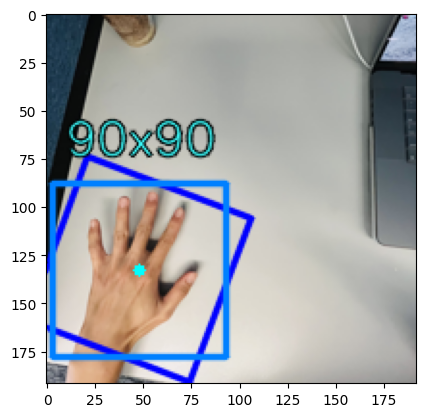

In [ ]:
# visualize_palm()
# visualize_palm(postprocess_palms(np.array(img), onnx_preds), np.array(img))

palms = res
img_ = np.array(img)
debug_image = img_.copy()

cap_width = img_.shape[1]
cap_height = img_.shape[0]
# cap_width = 224 # DEBUG
# cap_height = 224 # DEBUG
wh_ratio = 1
rects = []

if len(palms) > 0:
    for palm in palms:
        sqn_rr_size = palm[0]
        rotation = palm[1]
        sqn_rr_center_x = palm[2]
        sqn_rr_center_y = palm[3]

        cx = int(sqn_rr_center_x * cap_width)
        cy = int(sqn_rr_center_y * cap_height)
        xmin = int((sqn_rr_center_x - (sqn_rr_size / 2)) * cap_width)
        xmax = int((sqn_rr_center_x + (sqn_rr_size / 2)) * cap_width)
        ymin = int((sqn_rr_center_y - (sqn_rr_size * wh_ratio / 2)) * cap_height)
        ymax = int((sqn_rr_center_y + (sqn_rr_size * wh_ratio / 2)) * cap_height)
        xmin = max(0, xmin)
        xmax = min(cap_width, xmax)
        ymin = max(0, ymin)
        ymax = min(cap_height, ymax)
        # degree = degrees(rotation)
        # degree = math.cos(math.radians(rotation))
        degree = math.degrees(rotation)
        rects.append([cx, cy, (xmax-xmin), (ymax-ymin), degree])

    rects = np.asarray(rects, dtype=np.float32)

    # Debug
    for rect in rects:
        rects_tuple = ((rect[0], rect[1]), (rect[2], rect[3]), rect[4])
        box = cv2.boxPoints(rects_tuple).astype(np.int0)
        cv2.drawContours(debug_image, [box], 0,(0,0,255), 2, cv2.LINE_AA)

        rcx = int(rect[0])
        rcy = int(rect[1])
        half_w = int(rect[2] // 2)
        half_h = int(rect[3] // 2)
        x1 = rcx - half_w
        y1 = rcy - half_h
        x2 = rcx + half_w
        y2 = rcy + half_h
        text_x = max(x1, 10)
        text_x = min(text_x, cap_width-120)
        text_y = max(y1-15, 45)
        text_y = min(text_y, cap_height-20)
        # not_rotate_rects.append([rcx, rcy, x1, y1, x2, y2, 0])
        cv2.putText(
            debug_image,
            f'{y2-y1}x{x2-x1}',
            (text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            (0,0,0),
            2,
            cv2.LINE_AA,
        )
        cv2.putText(
            debug_image,
            f'{y2-y1}x{x2-x1}',
            (text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            (59,255,255),
            1,
            cv2.LINE_AA,
        )
        cv2.rectangle(
            debug_image,
            (x1,y1),
            (x2,y2),
            (0,128,255),
            2,
            cv2.LINE_AA,
        )
        cv2.circle(
            debug_image,
            (rcx, rcy),
            3,
            (0, 255, 255),
            -1,
        )

        base_point = np.asarray(
            [rcx, rcy],
            dtype=np.float32,
        )
        # points = np.asarray(
        #     list(palm_trackid_cxcy.values()),
        #     dtype=np.float32,
        # )


# Get the palm images with corrected rotation angles
cropped_rotated_hands_images = utils.rotate_and_crop_rectangle(
    image=img_,
    rects_tmp=rects,
    operation_when_cropping_out_of_range='padding',
)

# if len(cropped_rotated_hands_images) > 0:

#     hand_landmarks, rotated_image_size_leftrights = hand_landmark(
#         images=cropped_rotated_hands_images,
#         rects=rects,
#     )

#     if len(hand_landmarks) > 0:
#         pre_processed_landmarks = []
#         pre_processed_point_histories = []
#         for (trackid, x1y1), landmark, rotated_image_size_leftright, not_rotate_rect in \
#             zip(palm_trackid_box_x1y1s.items(), hand_landmarks, rotated_image_size_leftrights, not_rotate_rects):

#             x1, y1 = x1y1
#             rotated_image_width, _, left_hand_0_or_right_hand_1 = rotated_image_size_leftright
#             thick_coef = rotated_image_width / 400
#             lines = np.asarray(
#                 [
#                     np.array([landmark[point] for point in line]).astype(np.int32) for line in lines_hand
#                 ]
#             )
#             radius = int(1+thick_coef*5)
#             cv2.polylines(
#                 debug_image,
#                 lines,
#                 False,
#                 (255, 0, 0),
#                 int(radius),
#                 cv2.LINE_AA,
#             )

viz = debug_image.copy()
plt.imshow(viz)
plt.show()

/tmp/ipykernel_7207/1500101132.py:19: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = cv2.boxPoints(rects_tuple).astype(np.int0)


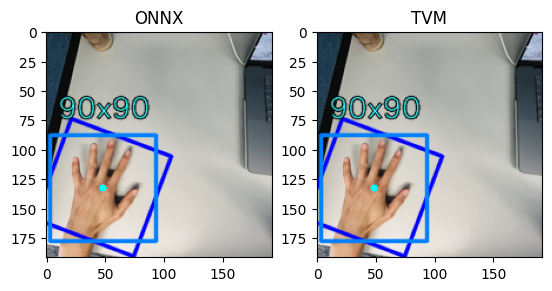

In [ ]:
plt.subplot(1, 2, 1)
plt.title("ONNX")
plt.imshow(visualize_palm(postprocess_palms(np.array(img), onnx_preds), np.array(img)))
# plt.imshow(visualize_palm(postprocess_palms(np.array(img), onnx_preds_alt), np.array(img)))

plt.subplot(1, 2, 2)
plt.title("TVM")
plt.imshow(visualize_palm(postprocess_palms(np.array(img), tvm_outputs), np.array(img)))
plt.show()

## Evaluate

In [30]:
# %%capture
# more test images
!wget 'https://github.com/k2m5t2/assets/blob/master/test_images/hand/center.jpg?raw=true' -O 'test_images/center.jpg'
!wget 'https://github.com/k2m5t2/assets/blob/master/test_images/hand/flipped.jpg?raw=true' -O 'test_images/flipped.jpg'
!wget 'https://github.com/k2m5t2/assets/blob/master/test_images/hand/top_left.jpg?raw=true' -O 'test_images/top_left.jpg'
!wget 'https://github.com/k2m5t2/assets/blob/master/test_images/hand/top_right.jpg?raw=true' -O 'test_images/top_right.jpg'
!wget 'https://github.com/k2m5t2/assets/blob/master/test_images/hand/top_right2.jpg?raw=true' -O 'test_images/top_right2.jpg'
!wget 'https://github.com/k2m5t2/assets/blob/master/test_images/hand/bottom_left.jpg?raw=true' -O 'test_images/bottom_left.jpg'
!wget 'https://github.com/k2m5t2/assets/blob/master/test_images/hand/bottom_right.jpg?raw=true' -O 'test_images/bottom_right.jpg'
!wget 'https://github.com/k2m5t2/assets/blob/master/test_images/hand/bottom_right.jpg?raw=true' -O 'test_images/bottom_right.jpg'
!wget 'https://github.com/k2m5t2/assets/blob/master/test_images/hand/bottom_right2.jpg?raw=true' -O 'test_images/bottom_right2.jpg'

--2024-02-18 22:50:01--  https://github.com/k2m5t2/assets/blob/master/test_images/hand/center.jpg?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/k2m5t2/assets/raw/master/test_images/hand/center.jpg [following]
--2024-02-18 22:50:02--  https://github.com/k2m5t2/assets/raw/master/test_images/hand/center.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/k2m5t2/assets/master/test_images/hand/center.jpg [following]
--2024-02-18 22:50:02--  https://raw.githubusercontent.com/k2m5t2/assets/master/test_images/hand/center.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connecte

In [ ]:
# onnx
onnx_preds = m.run(["pdscore_boxx_boxy_boxsize_kp0x_kp0y_kp2x_kp2y"], {"input": x})[0]
print(onnx_preds.shape)
onnx_pred = onnx_preds[0]

# tvm
tvm_preds = palm_ex(tvm.nd.array(x.astype(dtype))).numpy()
print(tvm_preds.shape)
tvm_pred = tvm_preds[0]

(379, 8)
(379, 8)


### Visualize

/tmp/ipykernel_7207/1500101132.py:19: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = cv2.boxPoints(rects_tuple).astype(np.int0)


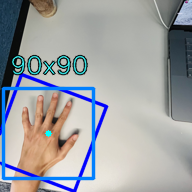

In [ ]:
imshow(visualize_palm(postprocess_palms(np.array(img), onnx_preds), np.array(img)))

/tmp/ipykernel_7207/1500101132.py:19: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = cv2.boxPoints(rects_tuple).astype(np.int0)


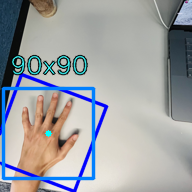

In [ ]:
imshow(visualize_palm(postprocess_palms(np.array(img), tvm_preds), np.array(img)))

Nice!

### Compare

Qualitative

In [ ]:
def palm_compare(fn, debug=False):
    img = Image.open("./test_images/"+fn).resize((size, size))
    x = np.array(img).transpose(2, 0, 1)[np.newaxis, ...].astype(dtype)/256

    onnx_preds = m.run(["pdscore_boxx_boxy_boxsize_kp0x_kp0y_kp2x_kp2y"], {"input": x})[0]
    onnx_pred = onnx_preds[0]
    if debug: print(onnx_pred)
    tvm_outputs = palm_ex(tvm.nd.array(x.astype(dtype))).numpy()
    tvm_output = tvm_outputs[0]
    if debug: print(tvm_output)

    plt.subplot(2, 2, 1)
    plt.title("ONNX")
    plt.axis('off')
    plt.imshow(visualize_palm(postprocess_palms(np.array(img), onnx_preds), np.array(img)))

    plt.subplot(2, 2, 2)
    plt.title("TVM")
    plt.axis('off')
    plt.imshow(visualize_palm(postprocess_palms(np.array(img), tvm_outputs), np.array(img)))

    plt.subplot(2, 2, 3)
    plt.title("ONNX - cropped")
    plt.axis('off')
    plt.imshow(viz_processed_palm(onnx_preds, img))

    plt.subplot(2, 2, 4)
    plt.title("TVM - cropped")
    plt.axis('off')
    plt.imshow(viz_processed_palm(tvm_outputs, img))

    plt.show()

[0.9644846  0.4761136  0.5839513  0.23172772 0.43142968 0.69568425
 0.4701728  0.47878647]
[0.9644845  0.47611362 0.5839513  0.23172764 0.43142974 0.6956842
 0.47017282 0.47878647]


/tmp/ipykernel_7207/1500101132.py:19: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = cv2.boxPoints(rects_tuple).astype(np.int0)


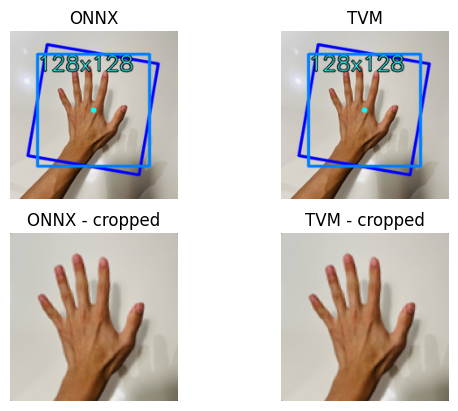

In [ ]:
palm_compare("center.jpg", debug=True)

/tmp/ipykernel_7207/1500101132.py:19: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = cv2.boxPoints(rects_tuple).astype(np.int0)


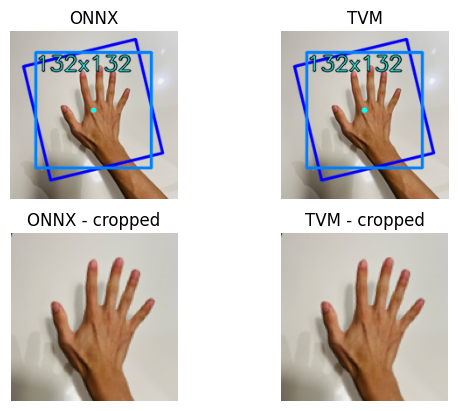

In [ ]:
palm_compare("flipped.jpg")

/tmp/ipykernel_7207/1500101132.py:19: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = cv2.boxPoints(rects_tuple).astype(np.int0)


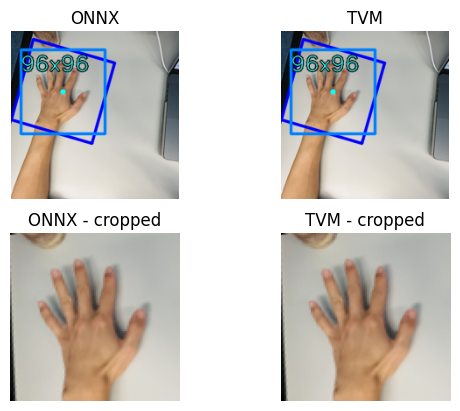

In [ ]:
palm_compare("top_left.jpg")

/tmp/ipykernel_7207/1500101132.py:19: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = cv2.boxPoints(rects_tuple).astype(np.int0)


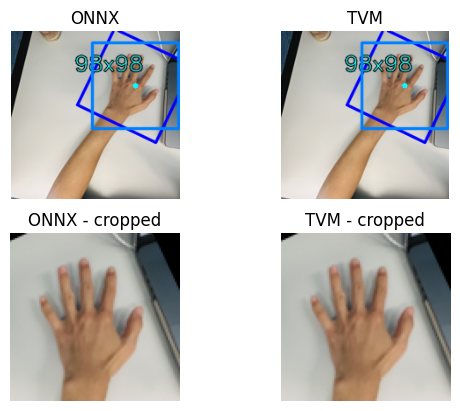

In [ ]:
palm_compare("top_right.jpg")

/tmp/ipykernel_7207/1500101132.py:19: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = cv2.boxPoints(rects_tuple).astype(np.int0)


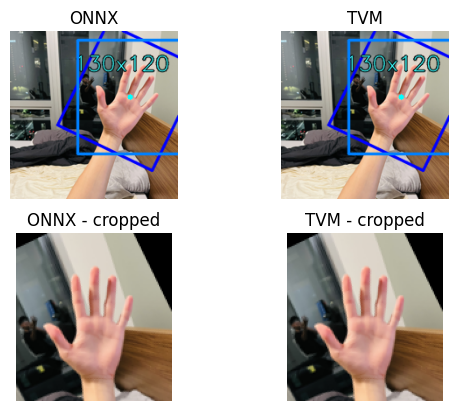

In [ ]:
palm_compare("top_right2.jpg")

/tmp/ipykernel_7207/1500101132.py:19: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = cv2.boxPoints(rects_tuple).astype(np.int0)


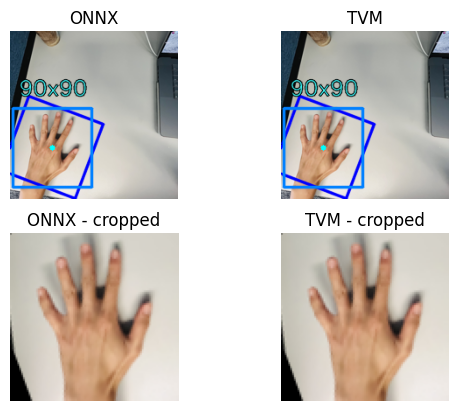

In [ ]:
palm_compare("bottom_left.jpg")

/tmp/ipykernel_7207/1500101132.py:19: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = cv2.boxPoints(rects_tuple).astype(np.int0)


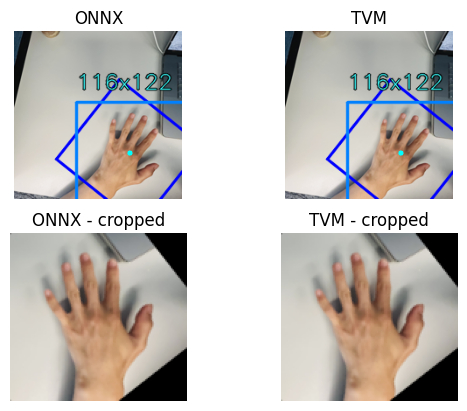

In [ ]:
palm_compare("bottom_right.jpg")

[0.99306834 0.6810613  0.68770725 0.1974123  0.6075044  0.7845665
 0.727847   0.62656415]
[0.99306834 0.6810613  0.68770725 0.1974123  0.6075044  0.7845665
 0.727847   0.62656415]


/tmp/ipykernel_7207/1500101132.py:19: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = cv2.boxPoints(rects_tuple).astype(np.int0)


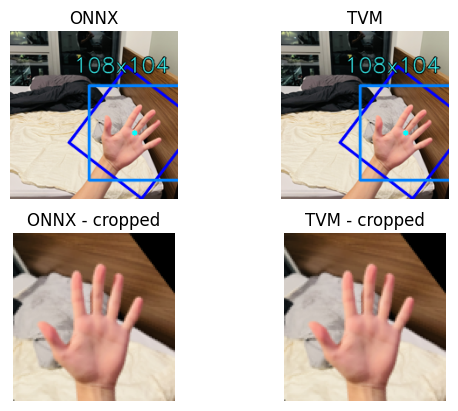

In [ ]:
palm_compare("bottom_right2.jpg", debug=True)

Quantitative

In [ ]:
print('Values:', onnx_pred)
print('Errors:', onnx_pred - tvm_pred)
print('Error (%):', round(np.mean(onnx_pred - tvm_pred)/np.mean(onnx_pred)*100, 5))

Values: [0.9479735  0.22151476 0.77379096 0.16392057 0.17025769 0.8559041
 0.22850657 0.70349777]
Errors: [ 1.1920929e-07  2.9802322e-08  0.0000000e+00 -1.4901161e-08
  0.0000000e+00  0.0000000e+00  2.9802322e-08  0.0000000e+00]
Error (%): 0.0


# Hand Landmark Detection

**`TODO` crop-rotate pre-processing step**. This is necessary for proper landmark detection.

## Model

In [ ]:
ldmk_file = './model/hand_landmark/hand_landmark_sparse_Nx3x224x224.onnx'

In [ ]:
ldmk_size = 224

### Diagnostics

### Update Opset Version

In [ ]:
ldmk_original = onnx.load(ldmk_file)
ldmk_updated = onnx.version_converter.convert_version(ldmk_original, 15)

onnx.save(ldmk_updated, ldmk_file)

### NNAPI/CoreML Compatibility

In [ ]:
! python -m onnxruntime.tools.check_onnx_model_mobile_usability {landmark_model}

/bin/bash: line 1: python: command not found


## Load

In [ ]:
ldmk_model = onnx.load(ldmk_file)

### Inspect

In [ ]:
print("Input:", ldmk_model.graph.input)
print("Output:", ldmk_model.graph.output)

Input: [name: "input"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "N"
      }
      dim {
        dim_value: 3
      }
      dim {
        dim_value: 224
      }
      dim {
        dim_value: 224
      }
    }
  }
}
]
Output: [name: "xyz_x21"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "N"
      }
      dim {
        dim_value: 63
      }
    }
  }
}
, name: "hand_score"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "N"
      }
      dim {
        dim_value: 1
      }
    }
  }
}
, name: "lefthand_0_or_righthand_1"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "N"
      }
      dim {
        dim_value: 1
      }
    }
  }
}
]


In [ ]:
start_netron(ldmk_file)

Serving './model/hand_landmark/hand_landmark_sparse_Nx3x224x224.onnx' at http://localhost:8081


## Test Image

In [ ]:
# real image
img_path = "./test_images/hand.jpg"
ldmk_img = Image.open(img_path).resize((ldmk_size, ldmk_size))
x2 = np.array(ldmk_img).transpose(2, 0, 1)[np.newaxis, ...].astype(np.float32)/256

## Build with Relay

In [ ]:
x2.shape

(1, 3, 224, 224)

In [ ]:
ldmk_input_name = "input"
ldmk_shape_dict = {input_name: x2.shape}
ldmk_mod, ldmk_params = relay.frontend.from_onnx(ldmk_model, ldmk_shape_dict)

In [ ]:
with tvm.transform.PassContext(opt_level=1):
    ldmk_ex = relay.build_module.create_executor(
        "vm", ldmk_mod, tvm.cpu(0), target, ldmk_params
    ).evaluate()

## Run Inference

TVM

In [ ]:
dtype = "float32"
ldmk_tvm_preds = ldmk_ex(tvm.nd.array(x2.astype(dtype)))[0].numpy()

ONNX

In [ ]:
ldmk_m = ort.InferenceSession(ldmk_file, providers=['CPUExecutionProvider'])
ldmk_onnx_preds = ldmk_m.run(["xyz_x21"], {"input": x2})

## Evaluate / Compare Results

In [ ]:
# onnx
ldmk_onnx_preds = ldmk_m.run(["xyz_x21"], {"input": x2})[0]
print(ldmk_onnx_preds.shape)
ldmk_onnx_pred = ldmk_onnx_preds[0]

# tvm
ldmk_tvm_preds = ldmk_ex(tvm.nd.array(x2.astype(dtype)))[0].numpy()
print(ldmk_tvm_preds.shape)
ldmk_tvm_pred = ldmk_tvm_preds[0]

(1, 63)
(1, 63)


### Quantitative

In [ ]:
print('Values:', np.round(ldmk_onnx_pred, 2))
print('Errors:', np.round(ldmk_onnx_pred - ldmk_tvm_pred), 5)
print('Error (%):', round(np.mean(ldmk_onnx_pred - ldmk_tvm_pred)/np.mean(ldmk_onnx_pred)*100, 5))

Values: [ 86.28 174.78   0.   116.36 153.99  -1.45 132.76 135.59  -2.27 142.95
 117.09  -2.58 152.35 102.68  -2.68 115.59 106.53  -2.37 123.21  81.27
  -2.21 127.25  67.42  -2.33 129.63  55.62  -2.49 101.99 104.84  -0.73
 104.74  75.33  -0.25 106.36  60.87  -0.46 106.5   49.54  -0.99  90.49
 108.54   1.16  88.88  83.85   1.73  88.02  69.94   0.74  86.93  57.84
  -0.37  81.12 116.94   3.15  74.17 100.46   3.47  70.33  90.75   2.91
  66.92  82.04   2.23]
Errors: [-0.  0.  0. -0.  0.  0. -0.  0. -0.  0.  0. -0. -0. -0.  0.  0.  0. -0.
 -0.  0. -0. -0.  0. -0. -0.  0. -0.  0.  0. -0. -0.  0. -0. -0.  0. -0.
  0. -0. -0. -0.  0. -0.  0.  0. -0.  0.  0. -0.  0. -0. -0.  0.  0.  0.
  0. -0.  0.  0. -0. -0.  0. -0. -0.] 5
Error (%): -0.0


In [ ]:
# NOTE graphically compare errors
# plt.plot(ldmk_onnx_pred, label='ONNX')
# plt.plot(ldmk_tvm_pred, label='TVM')
# plt.legend()
# plt.show()

### Qualitative

In [ ]:
def xyz_x21_to_yx(a):
    b = np.reshape(a, (21, 3))
    return b[:, 0:2]

In [ ]:
def visualize_landmarks_0(pred, img):
    plt.imshow(img)
    ldmks = xyz_x21_to_yx(pred)
    plt.scatter(ldmks[:, 0], ldmks[:, 1], c='w', s=10)

In [ ]:
def ldmk_compare(fn):
    # img = Image.open("./test_images/"+fn).resize((ldmk_size, ldmk_size))
    img = Image.open("./test_images/"+fn).resize((palm_size, palm_size))
    x = np.array(img).transpose(2, 0, 1)[np.newaxis, ...].astype(dtype)/256
    tvm_outputs = palm_ex(tvm.nd.array(x.astype(dtype))).numpy()
    palm = viz_processed_palm(tvm_outputs, img) # rotated, cropped palm
    palm = Image.fromarray(palm).resize((ldmk_size, ldmk_size)) # resize for ldmk model
    # x2 = np.array(img).transpose(2, 0, 1)[np.newaxis, ...].astype(dtype)/256
    x2 = np.array(palm).transpose(2, 0, 1)[np.newaxis, ...].astype(dtype)/256

    ldmk_onnx_preds = ldmk_m.run(["xyz_x21"], {"input": x2})[0]
    ldmk_onnx_pred = ldmk_onnx_preds[0]
    ldmk_tvm_preds = ldmk_ex(tvm.nd.array(x2.astype(dtype)))[0].numpy()
    ldmk_tvm_pred = ldmk_tvm_preds[0]

    plt.subplot(1, 2, 1)
    plt.title("ONNX")
    # visualize_landmarks_0(ldmk_onnx_pred, img)
    visualize_landmarks_0(ldmk_onnx_pred, palm)
    plt.subplot(1, 2, 2)
    plt.title("TVM")
    # visualize_landmarks_0(ldmk_tvm_pred, img)
    visualize_landmarks_0(ldmk_tvm_pred, palm)
    plt.show()

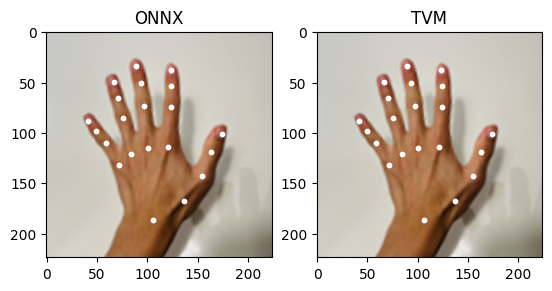

In [ ]:
ldmk_compare("center.jpg")

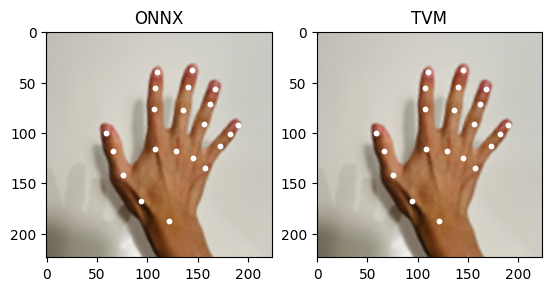

In [ ]:
ldmk_compare("flipped.jpg")

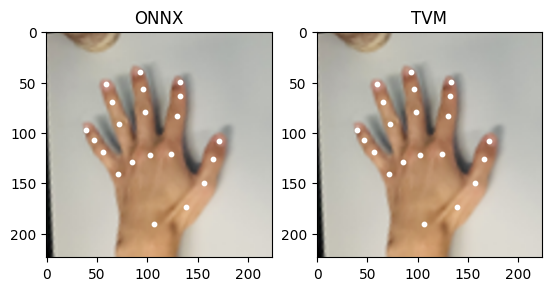

In [ ]:
ldmk_compare("top_left.jpg")

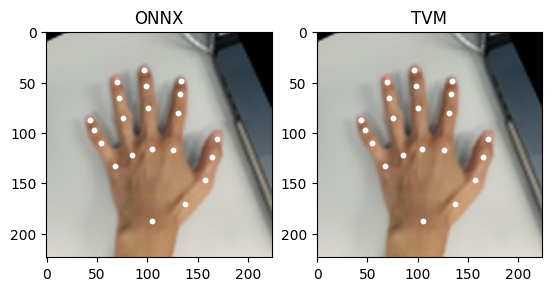

In [ ]:
ldmk_compare("top_right.jpg")

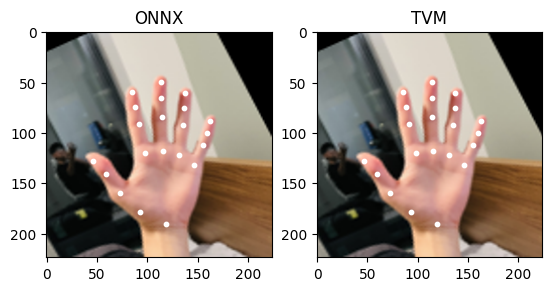

In [ ]:
ldmk_compare("top_right2.jpg")

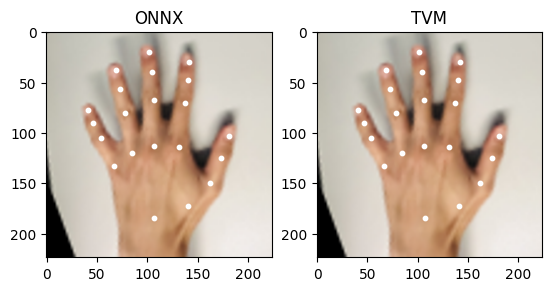

In [ ]:
ldmk_compare("bottom_left.jpg")

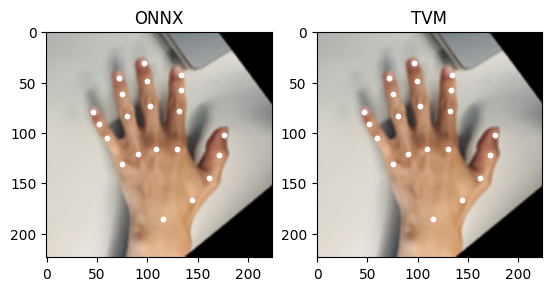

In [ ]:
ldmk_compare("bottom_right.jpg")

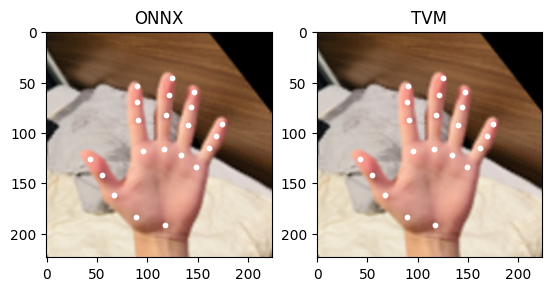

In [ ]:
ldmk_compare("bottom_right2.jpg")

`TODO` perhaps a better viz function (based on hand-onnx repo?) (including lines, maybe colors)

In [ ]:
# visualize
def visualize_landmarks(hand_landmarks, img):
    if len(hand_landmarks) > 0:
        pre_processed_landmarks = []
        pre_processed_point_histories = []
        for (trackid, x1y1), landmark, rotated_image_size_leftright, not_rotate_rect in \
            zip(palm_trackid_box_x1y1s.items(), hand_landmarks, rotated_image_size_leftrights, not_rotate_rects):

            x1, y1 = x1y1
            rotated_image_width, _, left_hand_0_or_right_hand_1 = rotated_image_size_leftright
            thick_coef = rotated_image_width / 400
            lines = np.asarray(
                [
                    np.array([landmark[point] for point in line]).astype(np.int32) for line in lines_hand
                ]
            )
            radius = int(1+thick_coef*5)
            cv2.polylines(
                img,
                lines,
                False,
                (255, 0, 0),
                int(radius),
                cv2.LINE_AA,
            )
            _ = [cv2.circle(img, (int(x), int(y)), radius, (0,128,255), -1) for x,y in landmark[:,:2]]
            left_hand_0_or_right_hand_1 = left_hand_0_or_right_hand_1 # if args.disable_image_flip else (1 - left_hand_0_or_right_hand_1)
            handedness = 'Left ' if left_hand_0_or_right_hand_1 == 0 else 'Right'
            _, _, x1, y1, _, _, _ = not_rotate_rect
            text_x = max(x1, 10)
            # text_x = min(text_x, cap_width-120)
            text_y = max(y1-70, 20)
            # text_y = min(text_y, cap_height-70)
            cv2.putText(
                img,
                f'trackid:{trackid} {handedness}',
                (text_x, text_y),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (0,0,0),
                2,
                cv2.LINE_AA,
            )
            cv2.putText(
                img,
                f'trackid:{trackid} {handedness}',
                (text_x, text_y),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (59,255,255),
                1,
                cv2.LINE_AA,
            )

            # pre_processed_landmark = pre_process_landmark(
            #     landmark,
            # )
            # pre_processed_landmarks.append(pre_processed_landmark)

In [ ]:
# cv2_imshow(cv2.cvtColor(visualize_palm([onnx_pred], np.array(test_img)), cv2.COLOR_BGR2RGB))

In [ ]:
# cv2_imshow(cv2.cvtColor(visualize_palm([tvm_pred], np.array(test_img)), cv2.COLOR_BGR2RGB))

# Optimize

Let's skip optimization for now. Must do a couple of Relax/Metaschedule examples before going ahead. (Which means, let's get TVM Guru built first!)

- Test inference @ different runtimes ()
- Benchmark
- RPC

In [ ]:
import tvm.meta_schedule as ms
from tvm import runtime, transform
from tvm.ir.module import IRModule
from typing import Dict
from tvm.target.target import Target

In [ ]:
num_trials = 1000

In [ ]:
work_dir = './tune_tmp'

In [ ]:
target = 'llvm -num-cores 8'

In [ ]:
def apply_opt_before_tuning(relay_mod: IRModule, params: Dict[str, runtime.NDArray] = None, target: Target = None):
    with transform.PassContext(opt_level=3):
        relay_mod = relay.transform.SimplifyInference()(relay_mod)
        relay_mod = relay.transform.FoldConstant()(relay_mod)
        relay_mod = relay.transform.FoldScaleAxis()(relay_mod)
        relay_mod = relay.transform.CanonicalizeOps()(relay_mod)
        relay_mod = relay.transform.AlterOpLayout()(relay_mod)
        relay_mod = relay.transform.FoldConstant()(relay_mod)

    return relay_mod

In [ ]:
palm_mod_opt1 = apply_opt_before_tuning(palm_mod)

In [ ]:
def tune(mod, params):
    db = ms.relay_integration.tune_relay(
        mod=mod,
        params=params,
        target=target,
        max_trials_global=num_trials*60,
        max_trials_per_task=num_trials,
        num_trials_per_iter=64,
        # runner=get_runner(),
        work_dir=work_dir,
    )
    return db

In [ ]:
# palm_relay_db = tune(palm_mod_opt1, palm_params)

# Compile

In [ ]:
dir(tvm.runtime)

['DataType',
 'DataTypeCode',
 'Device',
 'Module',
 'NDArray',
 'Object',
 'ObjectGeneric',
 'ObjectPath',
 'ObjectPathPair',
 'ObjectTypes',
 'PackedFunc',
 'Report',
 'Scriptable',
 'ShapeTuple',
 'String',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_ffi_api',
 '_ffi_node_api',
 'cl',
 'const',
 'container',
 'convert',
 'convert_to_object',
 'cpu',
 'cuda',
 'device',
 'enabled',
 'executor',
 'ext_dev',
 'gpu',
 'load_module',
 'load_param_dict',
 'load_param_dict_from_file',
 'load_static_library',
 'metal',
 'module',
 'mtl',
 'name_transforms',
 'ndarray',
 'num_threads',
 'object',
 'object_generic',
 'object_path',
 'opencl',
 'packed_func',
 'params',
 'profiling',
 'rocm',
 'save_param_dict',
 'save_param_dict_to_file',
 'script_printer',
 'system_lib',
 'vm',
 'vpi',
 'vulkan']

In [ ]:
dir(tvm.runtime.vm)

['Executable',
 'Module',
 'Object',
 'RPC_SESS_MASK',
 'TVMByteArray',
 'VirtualMachine',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_base',
 '_convert',
 '_ffi_api',
 'container',
 'convert',
 'np',
 'tvm']

In [ ]:
# from tvm import relax

In [ ]:
# from tvm.relax.testing import relay_translator
# import tvm.relax.testing.relay_translator
import tvm.relay

In [ ]:
import tvm.relay.backend

In [ ]:
exct = tvm.relay.backend.Executor("vm")

TVMError: TVMError: Executor "vm" is not defined

In [ ]:
# executor that is already created during import step

palm_ex = relay.build_module.create_executor(
        # "graph", mod, tvm.cpu(0), target, params
        "vm", palm_mod, tvm.cpu(0), target, palm_params
    ).evaluate()

In [ ]:
# # NOTE so maybe this isn't needed at all!
ex = tvm.relay.build(ir_mod=palm_mod, target="llvm", executor=exct)

In [ ]:
# the model involves dynamic shape, requiring use of relax
# however, relax fails to import except at latest builds of TVM
# yet the latest builds suffer from TIR.ProducerLoad error.
# all in all, best bet is to go ahead with what exists so far.

# palm_rxt_mod = relay_translator.from_relay(palm_mod["main"], target)

In [ ]:
# palm_rxt_ex = relax.build(ir_mod=palm_rxt_mod, target="llvm")

In [ ]:
palm_ex.export_library("./mp_hands_palm.so")

AttributeError: 'function' object has no attribute 'export_library'

In [ ]:
palm_ex

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_copyto',
 '_create_view',
 '_tvm_handle',
 'asnumpy',
 'copyfrom',
 'copyto',
 'device',
 'dtype',
 'handle',
 'is_view',
 'numpy',
 'same_as',
 'shape',
 'to_dlpack']

In [ ]:
dir(palm_ex)

['__annotations__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [ ]:
!exec ./mp_hands_palm/so

# Deploy

Targets:

- C++
- Wasm
- Android
- iOS
- Flutter

## C++

In [ ]:
device = tvm.cpu()

In [ ]:
palm_dex = tvm.runtime.load_module("./mp_hands_palm.so")
palm_dvm = relay.VirtualMachine(rt_mod=palm_dex, device=device)

In [ ]:
palm_dvm_preds = palm_dvm["main"](tvm.nd.array(x2.astype(dtype))).numpy()

In [ ]:
palm_dvm_preds[0, 0, ...]
# plt.imshow(palm_dvm_preds[0, 0, ...])

# Apply

- infer, visualize in real time @ Flutter (w/ Pixel)

# Notes